# 📌 Prediksi Rating Tempat Wisata (Laode)

Notebook ini bertujuan membangun model prediksi rating tempat wisata berdasarkan fitur seperti kota, kategori, harga, dan lokasi.

## 🎯 Tujuan
- Prediksi rating dari sudut pandang pengguna (`Place_Ratings`)
- Prediksi rating rata-rata tempat wisata (`Rating`)

Model yang digunakan:
- Decision Tree Regressor
- MLP Regressor (Neural Network)

## 📥 Import Library & Load Dataset

In [ ]:
!pip install tensorflow


In [ ]:
# 📊 Analisis Data
import pandas as pd
import numpy as np

# 📈 Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# 🧹 Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# 📐 Evaluasi & Similarity
from sklearn.metrics.pairwise import cosine_similarity

# 🧠 Machine Learning - Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import nltk
import joblib
# 📝 NLP (Text Processing)
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer

# 📂 Google Colab
from google.colab import files


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving tourism_with_id.csv to tourism_with_id.csv
Saving user.csv to user.csv
Saving package_tourism.csv to package_tourism.csv
Saving tourism_rating.csv to tourism_rating.csv


In [ ]:
# Membaca dataset
df_user = pd.read_csv('user.csv')
df_tourism = pd.read_csv('tourism_with_id.csv')
df_rating = pd.read_csv('tourism_rating.csv')
df_package = pd.read_csv('package_tourism.csv')

## 📊 Eksplorasi Data Awal

In [ ]:
print("Info User Dataset:")
print(df_user.info(), "\n")

print("Info Tourism Dataset:")
print(df_tourism.info(), "\n")

print("Info Tourism Rating Dataset:")
print(df_rating.info(), "\n")

print("Info Package Tourism Dataset:")
print(df_package.info(), "\n")


Info User Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB
None 

Info Tourism Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-nul

In [ ]:
# Kolom yang ingin dihapus
columns_to_drop_tourism = ['Place_Name', 'Description', 'Coordinate', 'Unnamed: 11', 'Unnamed: 12']
columns_to_drop_package = ['Place_Tourism4', 'Place_Tourism5']

# Hapus kolom yang tidak relevan dari setiap dataset
df_tourism.drop(columns=[col for col in columns_to_drop_tourism if col in df_tourism.columns], inplace=True)
df_package.drop(columns=[col for col in columns_to_drop_package if col in df_package.columns], inplace=True)

# Cek hasil pembersihan
print("Tourism Dataset setelah pembersihan:")
print(df_tourism.head(), "\n")

print("Package Dataset setelah pembersihan:")
print(df_package.head(), "\n")


Tourism Dataset setelah pembersihan:
   Place_Id       Category     City   Price  Rating  Time_Minutes       Lat  \
0         1         Budaya  Jakarta   20000     4.6          15.0 -6.175392   
1         2         Budaya  Jakarta       0     4.6          90.0 -6.137645   
2         3  Taman Hiburan  Jakarta  270000     4.6         360.0 -6.125312   
3         4  Taman Hiburan  Jakarta   10000     4.5           NaN -6.302446   
4         5  Taman Hiburan  Jakarta   94000     4.5          60.0 -6.124190   

         Long  
0  106.827153  
1  106.817125  
2  106.833538  
3  106.895156  
4  106.839134   

Package Dataset setelah pembersihan:
   Package     City         Place_Tourism1      Place_Tourism2  \
0        1  Jakarta      Pasar Tanah Abang        Taman Ayodya   
1        2  Jakarta      Pasar Tanah Abang  Pasar Taman Puring   
2        3  Jakarta  Perpustakaan Nasional               Monas   
3        4  Jakarta           Pulau Tidung      Pulau Bidadari   
4        5  Jakarta  Mu

In [ ]:
print("Missing values in df_package:\n", df_package.isnull().sum())
print("\nMissing values in df_rating:\n", df_rating.isnull().sum())
print("\nMissing values in df_tourism:\n", df_tourism.isnull().sum())
print("\nMissing values in df_user:\n", df_user.isnull().sum())



Missing values in df_package:
 Package           0
City              0
Place_Tourism1    0
Place_Tourism2    0
Place_Tourism3    0
dtype: int64

Missing values in df_rating:
 User_Id          0
Place_Id         0
Place_Ratings    0
dtype: int64

Missing values in df_tourism:
 Place_Id          0
Category          0
City              0
Price             0
Rating            0
Time_Minutes    232
Lat               0
Long              0
dtype: int64

Missing values in df_user:
 User_Id     0
Location    0
Age         0
dtype: int64


In [ ]:
print("Duplicates in df_package:", df_package.duplicated().sum())
print("Duplicates in df_rating:", df_rating.duplicated().sum())
print("Duplicates in df_tourism:", df_tourism.duplicated().sum())
print("Duplicates in df_user:", df_user.duplicated().sum())


Duplicates in df_package: 0
Duplicates in df_rating: 79
Duplicates in df_tourism: 0
Duplicates in df_user: 0


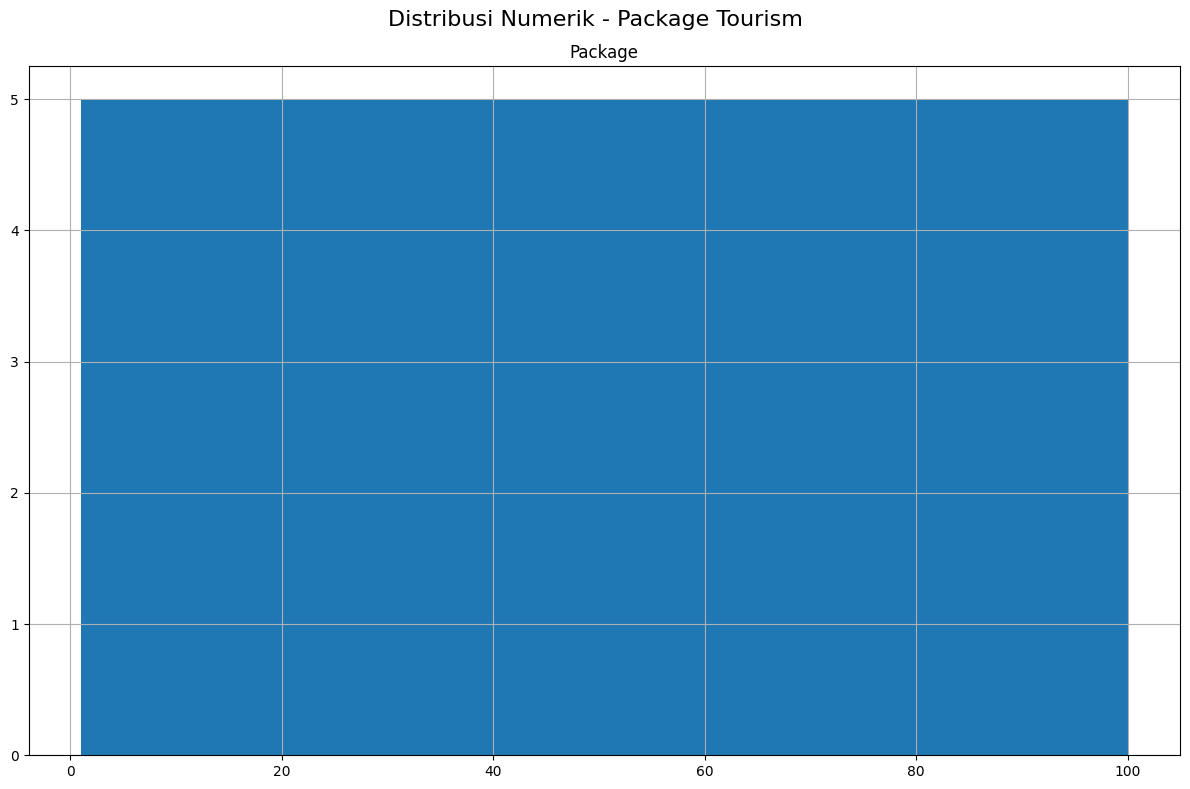

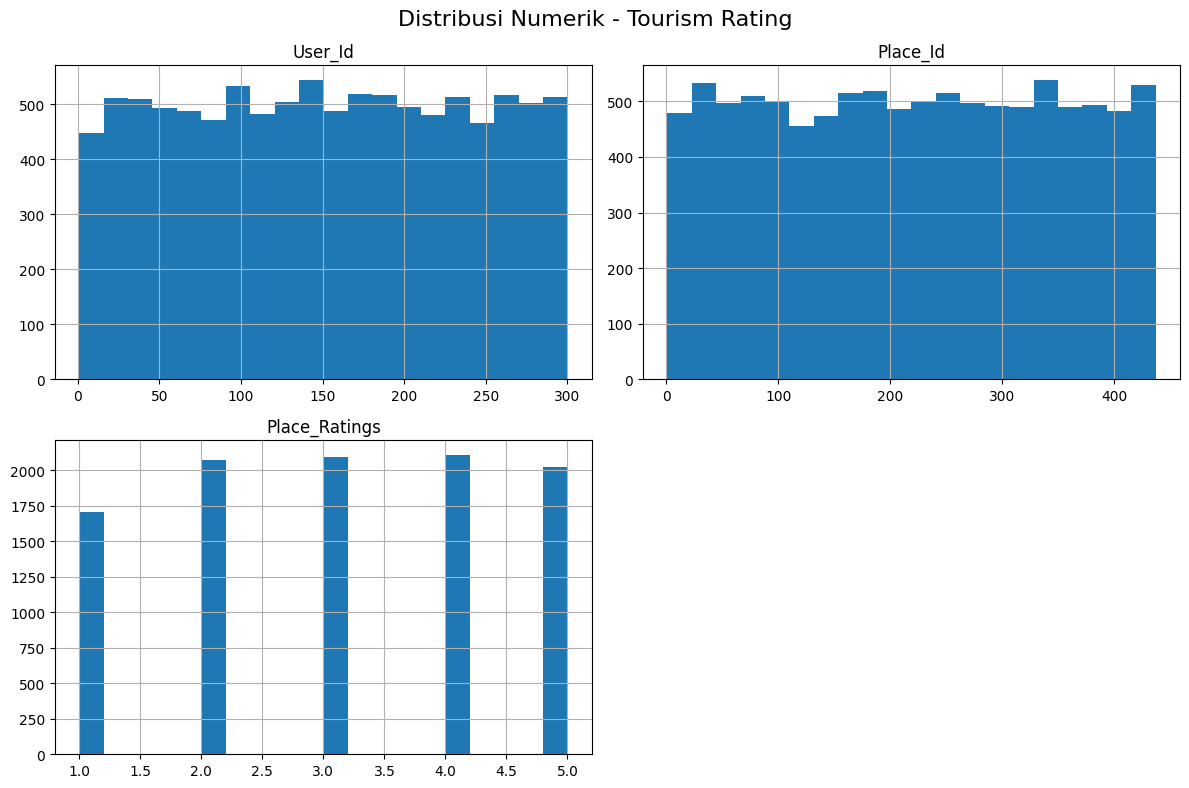

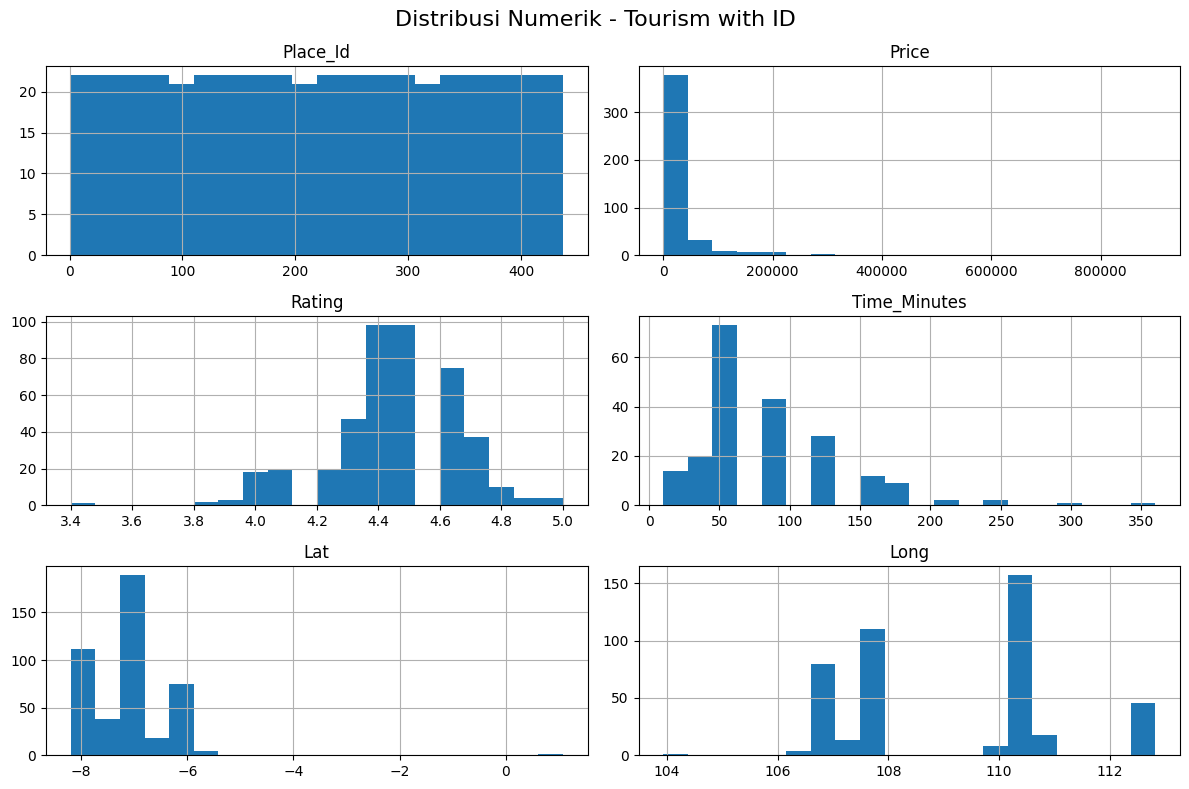

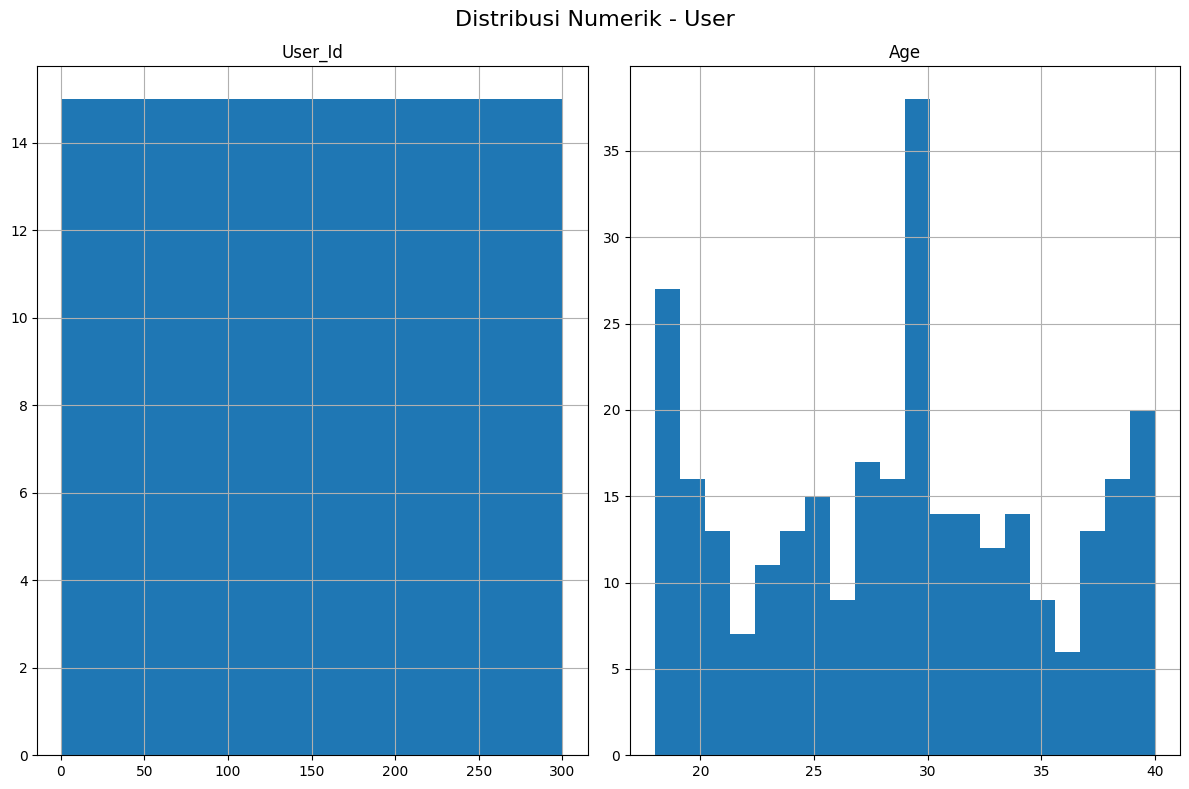

In [ ]:
# Buat list DataFrame numerik
numeric_dfs = [
    df_package.select_dtypes(include='number'),
    df_rating.select_dtypes(include='number'),
    df_tourism.select_dtypes(include='number'),
    df_user.select_dtypes(include='number')
]

# Judul plot untuk setiap DataFrame
titles = ['Package Tourism', 'Tourism Rating', 'Tourism with ID', 'User']

# Loop untuk plotting histogram setiap dataset
for df, title in zip(numeric_dfs, titles):
    df.hist(bins=20, figsize=(12, 8))
    plt.suptitle(f'Distribusi Numerik - {title}', fontsize=16)
    plt.tight_layout()
    plt.show()


Menampilkan pairplot untuk: Package Tourism


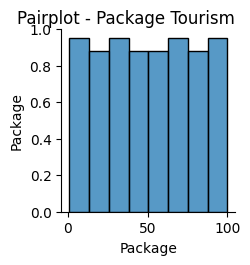

Menampilkan pairplot untuk: Tourism Rating


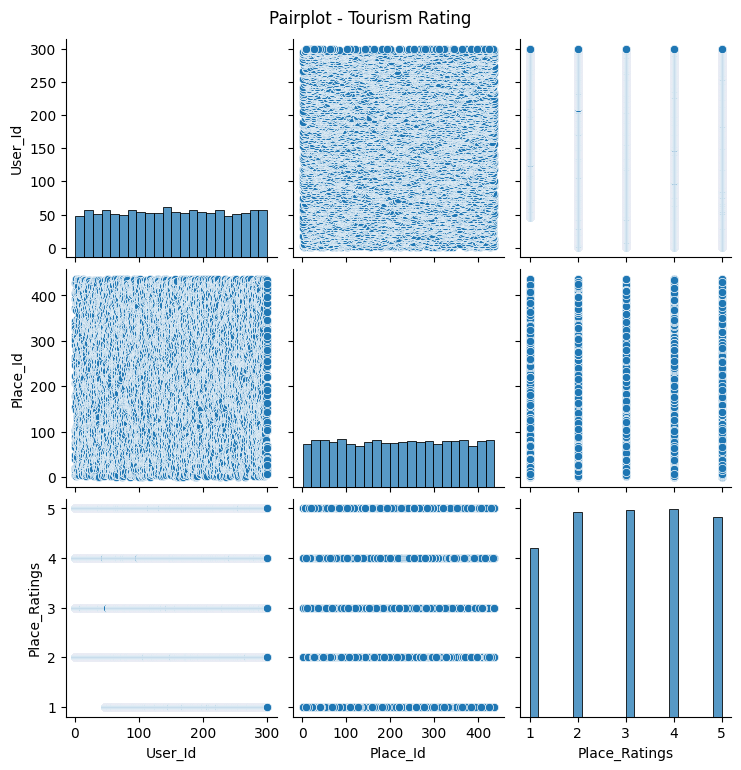

Pairplot dilewati untuk: Tourism with ID (jumlah kolom numerik > 5)
Menampilkan pairplot untuk: User


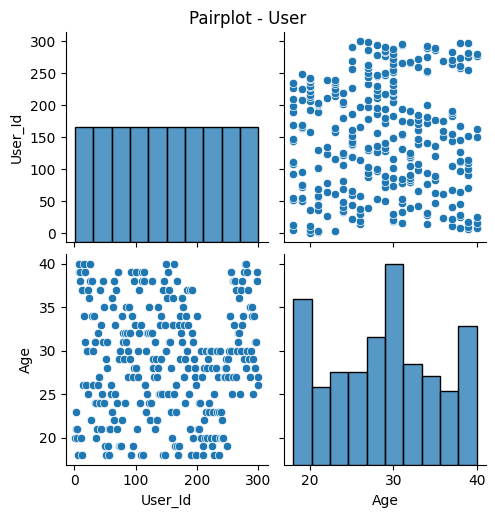

In [ ]:
# Ambil hanya fitur numerik dari setiap DataFrame
numeric_dfs = [
    df_package.select_dtypes(include='number'),
    df_rating.select_dtypes(include='number'),
    df_tourism.select_dtypes(include='number'),
    df_user.select_dtypes(include='number')
]

titles = ['Package Tourism', 'Tourism Rating', 'Tourism with ID', 'User']

# Plot pairplot hanya jika jumlah kolom numerik <= 5
for df, title in zip(numeric_dfs, titles):
    if df.shape[1] <= 5:  # batas maksimal kolom untuk pairplot
        print(f"Menampilkan pairplot untuk: {title}")
        sns.pairplot(df)
        plt.suptitle(f'Pairplot - {title}', y=1.02)
        plt.show()
    else:
        print(f"Pairplot dilewati untuk: {title} (jumlah kolom numerik > 5)")


Heatmap dilewati untuk: Package Tourism (jumlah kolom numerik terlalu sedikit)


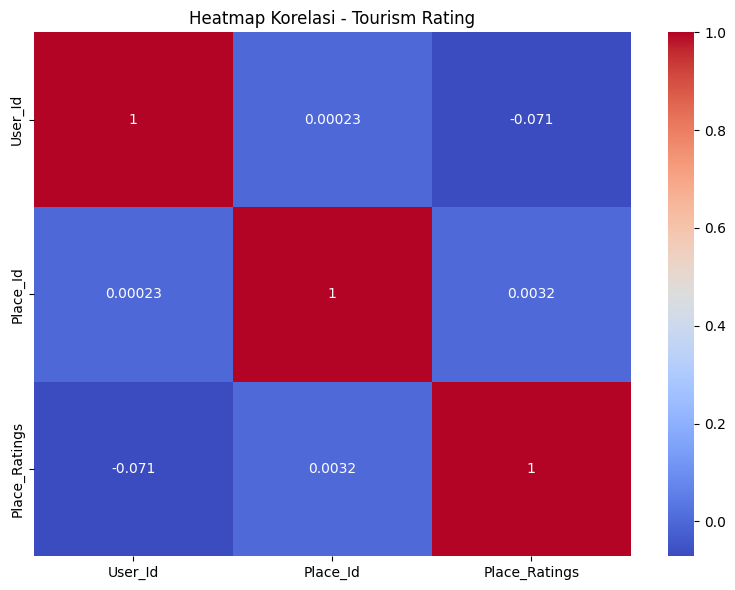

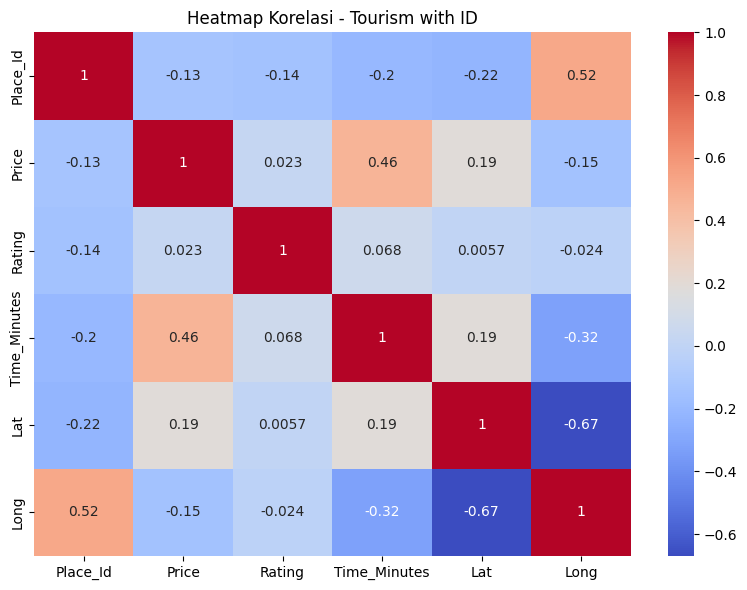

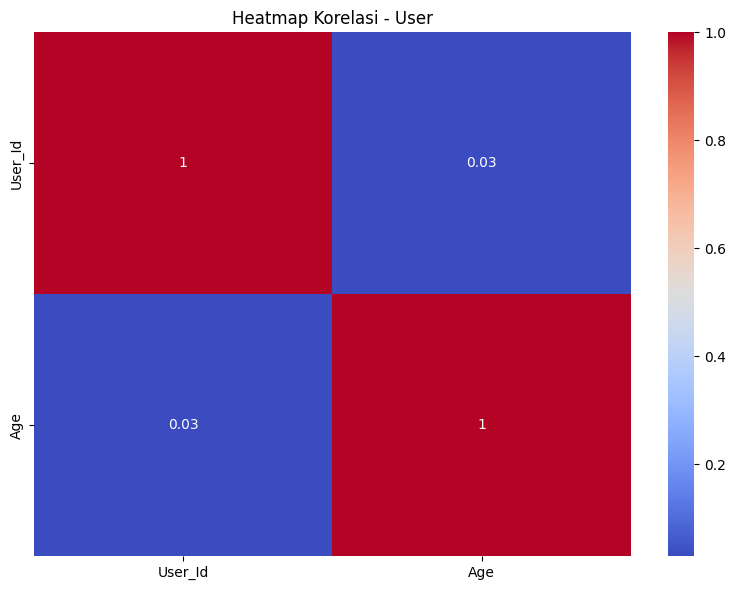

In [ ]:
# Ambil hanya kolom numerik dari masing-masing dataset
numeric_dfs = [
    df_package.select_dtypes(include='number'),
    df_rating.select_dtypes(include='number'),
    df_tourism.select_dtypes(include='number'),
    df_user.select_dtypes(include='number')
]

titles = ['Package Tourism', 'Tourism Rating', 'Tourism with ID', 'User']

# Tampilkan heatmap korelasi jika kolom numerik lebih dari 1
for df, title in zip(numeric_dfs, titles):
    if df.shape[1] > 1:
        plt.figure(figsize=(8, 6))
        sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
        plt.title(f'Heatmap Korelasi - {title}')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Heatmap dilewati untuk: {title} (jumlah kolom numerik terlalu sedikit)")


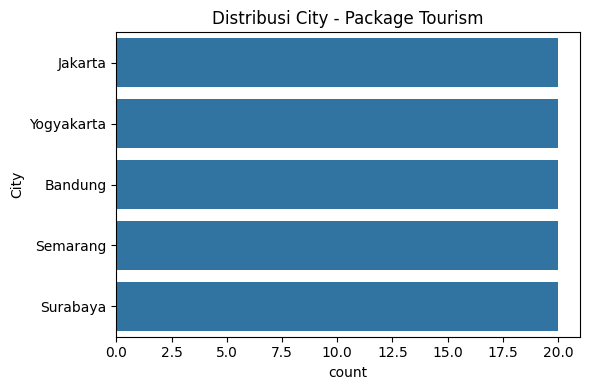

Kolom 'Place_Tourism1' di dataset 'Package Tourism' memiliki terlalu banyak kategori (89) - menampilkan top 15.


<ipython-input-12-60402905da20>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_categories.index, x=top_categories.values, palette='viridis')


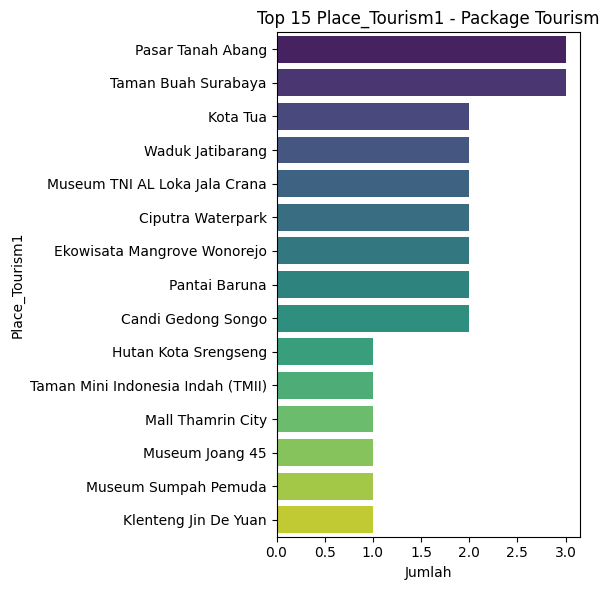

Kolom 'Place_Tourism2' di dataset 'Package Tourism' memiliki terlalu banyak kategori (93) - menampilkan top 15.


<ipython-input-12-60402905da20>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_categories.index, x=top_categories.values, palette='viridis')


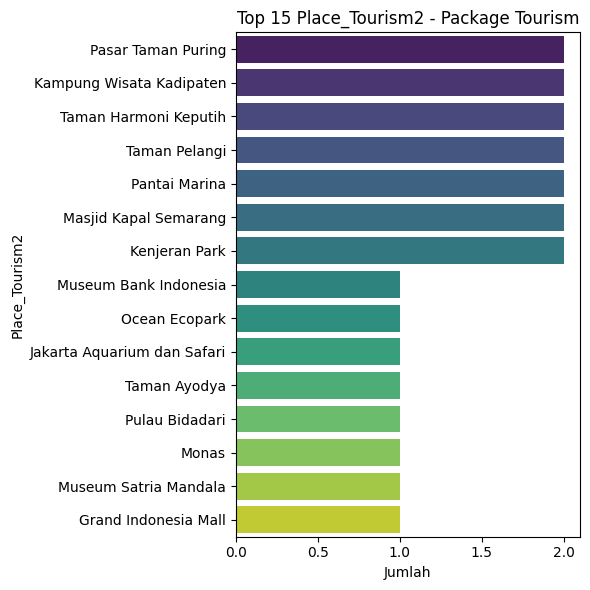

Kolom 'Place_Tourism3' di dataset 'Package Tourism' memiliki terlalu banyak kategori (92) - menampilkan top 15.


<ipython-input-12-60402905da20>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_categories.index, x=top_categories.values, palette='viridis')


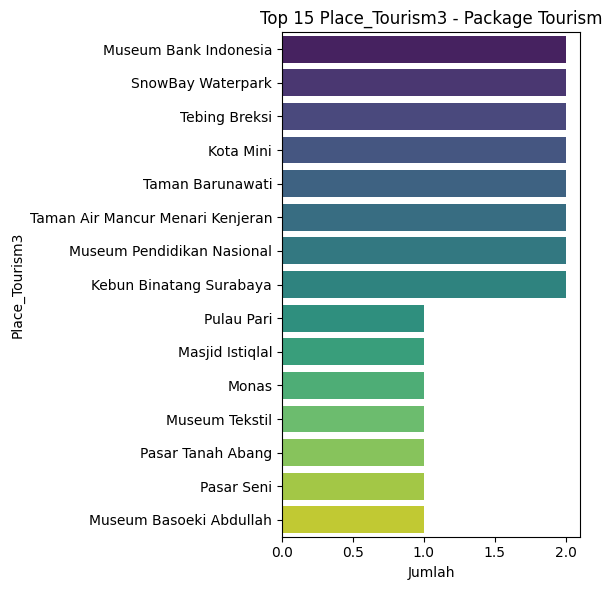

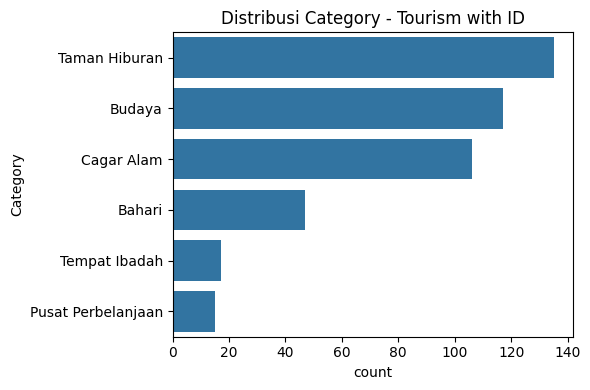

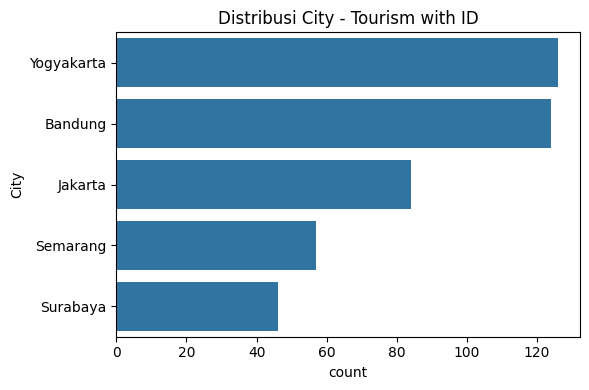

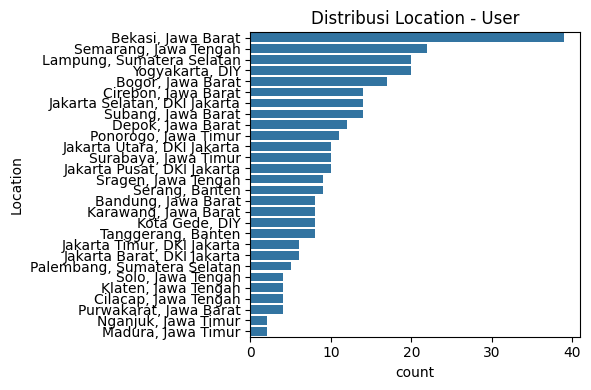

In [ ]:
categorical_dfs = [
    df_package.select_dtypes(include='object'),
    df_rating.select_dtypes(include='object'),
    df_tourism.select_dtypes(include='object'),
    df_user.select_dtypes(include='object')
]

titles = ['Package Tourism', 'Tourism Rating', 'Tourism with ID', 'User']

for df, title in zip(categorical_dfs, titles):
    for col in df.columns:
        unique_vals = df[col].nunique()
        if unique_vals < 30:
            # Visualisasi semua kategori
            plt.figure(figsize=(6, 4))
            sns.countplot(y=col, data=df, order=df[col].value_counts().index)
            plt.title(f'Distribusi {col} - {title}')
            plt.tight_layout()
            plt.show()
        else:
            # Visualisasi top 15 kategori saja
            print(f"Kolom '{col}' di dataset '{title}' memiliki terlalu banyak kategori ({unique_vals}) - menampilkan top 15.")
            top_categories = df[col].value_counts().nlargest(15)
            plt.figure(figsize=(6, 6))
            sns.barplot(y=top_categories.index, x=top_categories.values, palette='viridis')
            plt.title(f'Top 15 {col} - {title}')
            plt.xlabel('Jumlah')
            plt.tight_layout()
            plt.show()



In [ ]:
# Statistik deskriptif fitur kategorikal
for df, title in zip(categorical_dfs, titles):
    print(f"Statistik deskriptif fitur kategorikal - {title}:\n")
    # Tambahkan cek untuk memastikan DataFrame tidak kosong (memiliki kolom)
    if not df.empty and df.shape[1] > 0:
        print(df.describe(include='object'), "\n")
    else:
        print(f"DataFrame '{title}' tidak memiliki kolom bertipe 'object'.")
        print("\n")


Statistik deskriptif fitur kategorikal - Package Tourism:

           City     Place_Tourism1      Place_Tourism2         Place_Tourism3
count       100                100                 100                    100
unique        5                 89                  93                     92
top     Jakarta  Pasar Tanah Abang  Pasar Taman Puring  Museum Bank Indonesia
freq         20                  3                   2                      2 

Statistik deskriptif fitur kategorikal - Tourism Rating:

DataFrame 'Tourism Rating' tidak memiliki kolom bertipe 'object'.


Statistik deskriptif fitur kategorikal - Tourism with ID:

             Category        City
count             437         437
unique              6           5
top     Taman Hiburan  Yogyakarta
freq              135         126 

Statistik deskriptif fitur kategorikal - User:

                  Location
count                  300
unique                  28
top     Bekasi, Jawa Barat
freq                    39 



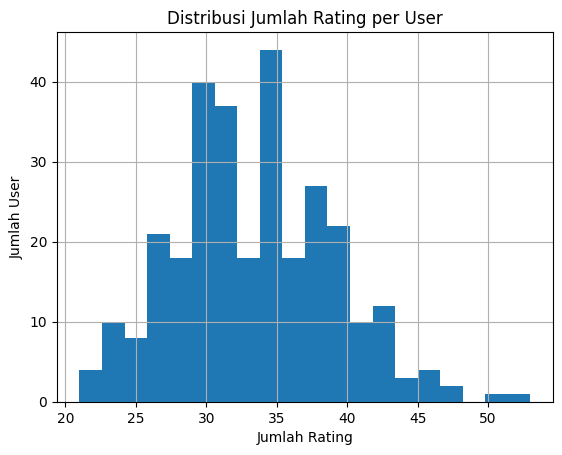

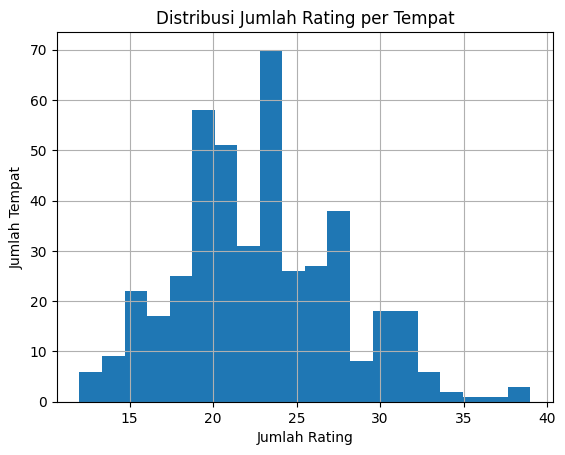

In [ ]:
# Distribusi jumlah rating per user
df_rating['User_Id'].value_counts().hist(bins=20)
plt.title("Distribusi Jumlah Rating per User")
plt.xlabel("Jumlah Rating")
plt.ylabel("Jumlah User")
plt.show()

# Distribusi jumlah rating per tempat
df_rating['Place_Id'].value_counts().hist(bins=20)
plt.title("Distribusi Jumlah Rating per Tempat")
plt.xlabel("Jumlah Rating")
plt.ylabel("Jumlah Tempat")
plt.show()


In [ ]:
# Gabungkan df_rating dan df_wisata berdasarkan Place_Id
rating_data = pd.merge(df_rating, df_tourism, on="Place_Id", how="left")

# Cek hasil merge
print(rating_data.head())


   User_Id  Place_Id  Place_Ratings       Category        City  Price  Rating  \
0        1       179              3         Budaya  Yogyakarta  75000     4.6   
1        1       344              2         Bahari    Semarang   3000     4.1   
2        1         5              5  Taman Hiburan     Jakarta  94000     4.5   
3        1       373              3         Budaya    Semarang  10000     4.5   
4        1       101              4         Budaya  Yogyakarta      0     4.0   

   Time_Minutes       Lat        Long  
0          90.0 -7.770542  110.489416  
1           NaN -6.948877  110.389329  
2          60.0 -6.124190  106.839134  
3          60.0 -7.264599  110.404602  
4           NaN -7.792190  110.362151  


## 🧹 Pra-pemrosesan & Pemodelan: Prediksi Rating oleh User

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Fitur dan target
X_user = rating_data[["City", "Category", "Price", "Lat", "Long"]]
y_user = rating_data["Place_Ratings"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_user, y_user, test_size=0.2, random_state=42)

# 1. One-Hot Encoding untuk kolom kategorikal dengan TensorFlow
city_lookup = tf.keras.layers.StringLookup(output_mode='one_hot')
category_lookup = tf.keras.layers.StringLookup(output_mode='one_hot')

# 2. Fit 'adapt' pada data kategori (harus dilakukan pada data training terlebih dahulu)
city_lookup.adapt(X_train["City"])
category_lookup.adapt(X_train["Category"])

# 3. Normalisasi untuk kolom numerik dengan StandardScaler dari scikit-learn
scaler = StandardScaler()

# Fit scaler pada data training dan normalisasi kolom numerik
X_train_scaled = X_train[["Price", "Lat", "Long"]].copy()
X_test_scaled = X_test[["Price", "Lat", "Long"]].copy()

X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

# 4. Preprocessing function
def preprocess_fn(X):
    # One-Hot Encoding untuk kolom 'City' dan 'Category'
    city_encoded = city_lookup(X["City"])
    category_encoded = category_lookup(X["Category"])

    # Pastikan tipe data satuan yang konsisten (konversi hasil one-hot menjadi float32)
    city_encoded = tf.cast(city_encoded, tf.float32)
    category_encoded = tf.cast(category_encoded, tf.float32)

    # Normalisasi kolom numerik yang sudah di-scaling dengan StandardScaler
    price_scaled = X[["Price"]].values
    lat_scaled = X[["Lat"]].values
    long_scaled = X[["Long"]].values

    # Gabungkan hasil preprocessing dengan konsistensi tipe data
    return tf.concat([city_encoded, category_encoded, price_scaled, lat_scaled, long_scaled], axis=1)

# Terapkan preprocessing pada data train dan test
X_train_processed = preprocess_fn(X_train)
X_test_processed = preprocess_fn(X_test)

# Convert label to numpy array
y_train = np.array(y_train)
y_test = np.array(y_test)

# Cek hasil preprocessing
print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"X_test_processed shape: {X_test_processed.shape}")


X_train_processed shape: (8000, 16)
X_test_processed shape: (2000, 16)


In [ ]:
# Arsitektur model TensorFlow/Keras
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_processed.shape[1],)),  # Input layer
    tf.keras.layers.Dense(64, activation='relu'),  # Hidden layer 1
    tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer 2
    tf.keras.layers.Dense(1)  # Output layer (regresi)
])

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# Training model
history = model.fit(X_train_processed, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2401633.7500 - mae: 363.9432 - val_loss: 5.3493 - val_mae: 1.6345
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.4179 - mae: 1.4346 - val_loss: 3.1524 - val_mae: 1.3776
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3002 - mae: 1.4980 - val_loss: 2.5275 - val_mae: 1.2986
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.7122 - mae: 1.6803 - val_loss: 18.4890 - val_mae: 2.1489
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 146.8709 - mae: 3.4355 - val_loss: 2.8037 - val_mae: 1.3477
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 79.6394 - mae: 2.3937 - val_loss: 63.4646 - val_mae: 3.2121
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 43.7995 - mae: 2.5565 - val_loss: 9020.0527 - val_mae: 30.8658
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 129327.2891 - mae: 52.2311 - val_loss: 956.1351 - val_mae: 15.0672
Epoch 9/50
225/225 ━━━━━━━━━━

In [ ]:
# Prediksi dengan model
y_pred_tf = model.predict(X_test_processed).flatten()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# Evaluasi dengan MAE dan RMSE
mae = mean_absolute_error(y_test, y_pred_tf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_tf))

# Tampilkan hasil evaluasi
print(f"✅ MAE (Keras): {mae:.4f}")
print(f"✅ RMSE (Keras): {rmse:.4f}")

✅ MAE (Keras): 1.5076
✅ RMSE (Keras): 1.8325


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Fitur dan target
X_user = rating_data[["City", "Category", "Price", "Lat", "Long"]]
y_user = rating_data["Place_Ratings"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_user, y_user, test_size=0.2, random_state=42)

# 1. One-Hot Encoding untuk kolom kategorikal dengan TensorFlow
city_lookup = tf.keras.layers.StringLookup(output_mode='one_hot')
category_lookup = tf.keras.layers.StringLookup(output_mode='one_hot')

# 2. Fit 'adapt' pada data kategori (harus dilakukan pada data training terlebih dahulu)
city_lookup.adapt(X_train["City"])
category_lookup.adapt(X_train["Category"])

# 3. Normalisasi untuk kolom numerik dengan StandardScaler dari scikit-learn
scaler = StandardScaler()

# Fit scaler pada data training dan normalisasi kolom numerik
X_train_scaled = X_train[["Price", "Lat", "Long"]].copy()
X_test_scaled = X_test[["Price", "Lat", "Long"]].copy()

X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

# 4. Preprocessing function
def preprocess_fn(X):
    # One-Hot Encoding untuk kolom 'City' dan 'Category'
    city_encoded = city_lookup(X["City"])
    category_encoded = category_lookup(X["Category"])

    # Pastikan tipe data satuan yang konsisten (konversi hasil one-hot menjadi float32)
    city_encoded = tf.cast(city_encoded, tf.float32)
    category_encoded = tf.cast(category_encoded, tf.float32)

    # Normalisasi kolom numerik yang sudah di-scaling dengan StandardScaler
    price_scaled = X[["Price"]].values
    lat_scaled = X[["Lat"]].values
    long_scaled = X[["Long"]].values

    # Gabungkan hasil preprocessing dengan konsistensi tipe data
    return tf.concat([city_encoded, category_encoded, price_scaled, lat_scaled, long_scaled], axis=1)

# Terapkan preprocessing pada data train dan test
X_train_processed = preprocess_fn(X_train)
X_test_processed = preprocess_fn(X_test)

# Convert label to numpy array
y_train = np.array(y_train)
y_test = np.array(y_test)

# Terapkan SMOTE untuk menghasilkan data sintetis
smote = SMOTE(random_state=42)

# Generate synthetic samples
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print(f"Original data size: {X_train.shape}")
print(f"Resampled data size: {X_train_resampled.shape}")

# Arsitektur model TensorFlow/Keras
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_resampled.shape[1],)),  # Input layer
    tf.keras.layers.Dense(64, activation='relu'),  # Hidden layer 1
    tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer 2
    tf.keras.layers.Dense(1)  # Output layer (regresi)
])

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Training model
history = model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Prediksi dengan model
y_pred_tf = model.predict(X_test_processed).flatten()

# Evaluasi dengan MAE dan RMSE
mae = mean_absolute_error(y_test, y_pred_tf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_tf))

# Tampilkan hasil evaluasi
print(f"✅ MAE (Keras): {mae:.4f}")
print(f"✅ RMSE (Keras): {rmse:.4f}")


Original data size: (8000, 5)
Resampled data size: (8465, 16)
Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 45832024.0000 - mae: 1154.8217 - val_loss: 96.2605 - val_mae: 7.5566
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 94.7904 - mae: 7.9989 - val_loss: 90.2630 - val_mae: 7.2852
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 87.4492 - mae: 7.5903 - val_loss: 73.3005 - val_mae: 7.2750
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 80.9054 - mae: 7.4195 - val_loss: 65.4484 - val_mae: 6.5185
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 70.8122 - mae: 6.8811 - val_loss: 52.9469 - val_mae: 6.1718
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 60.2333 - mae: 6.4056 - val_loss: 62.4531 - val_mae: 5.3088
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 47.4269 - mae: 5.6872 - val_loss: 35.1508 - val_mae: 4.8606
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 42.1560 - mae: 5.2814 - val_l

💾 Simpan model .h5:

In [ ]:
model.save("model_rating_user.h5")


💾 Simpan StandardScaler:

In [ ]:
import joblib
joblib.dump(scaler, "scaler_user.pkl")


['scaler_user.pkl']

💾 Simpan StringLookup layer:

In [ ]:
import pickle

with open("lookup_user_city.pkl", "wb") as f:
    pickle.dump(city_lookup, f)

with open("lookup_user_category.pkl", "wb") as f:
    pickle.dump(category_lookup, f)


## 🧠 Prediksi Rating Tempat Wisata (Bukan User-Based)

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Siapkan data tempat wisata
tempat_data = df_tourism.drop(columns=[
    "Place_Id", "Place_Name", "Coordinate", "Description",
    "Unnamed: 11", "Unnamed: 12"
], errors="ignore").dropna()

# Fitur & target
X_tempat = tempat_data[["City", "Category", "Price", "Lat", "Long"]]
y_tempat = tempat_data["Rating"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_tempat, y_tempat, test_size=0.2, random_state=42)

# 1. One-Hot Encoding untuk kolom kategorikal dengan TensorFlow
city_lookup = tf.keras.layers.StringLookup(output_mode='one_hot')
category_lookup = tf.keras.layers.StringLookup(output_mode='one_hot')

# 2. Fit 'adapt' pada data kategori (harus dilakukan pada data training terlebih dahulu)
city_lookup.adapt(X_train["City"])
category_lookup.adapt(X_train["Category"])

# 3. Normalisasi untuk kolom numerik dengan StandardScaler dari scikit-learn
scaler = StandardScaler()

# Fit scaler dan ganti langsung kolom numerik dalam DataFrame
X_train[["Price", "Lat", "Long"]] = scaler.fit_transform(X_train[["Price", "Lat", "Long"]])
X_test[["Price", "Lat", "Long"]] = scaler.transform(X_test[["Price", "Lat", "Long"]])

# 4. Preprocessing function (revisi fix)
def preprocess_fn(X):
    # Encode dengan StringLookup (ubah ke tf.constant agar bisa diproses)
    city_encoded = city_lookup(tf.constant(X["City"].values))
    category_encoded = category_lookup(tf.constant(X["Category"].values))

    # Konversi kolom numerik menjadi tensor
    price_scaled = tf.convert_to_tensor(X[["Price"]].values, dtype=tf.float32)
    lat_scaled = tf.convert_to_tensor(X[["Lat"]].values, dtype=tf.float32)
    long_scaled = tf.convert_to_tensor(X[["Long"]].values, dtype=tf.float32)

    # Gabungkan semua fitur menjadi satu tensor
    return tf.concat([tf.cast(city_encoded, tf.float32),
                      tf.cast(category_encoded, tf.float32),
                      price_scaled, lat_scaled, long_scaled], axis=1)

# Terapkan preprocessing
X_train_processed = preprocess_fn(X_train)
X_test_processed = preprocess_fn(X_test)

# Convert label ke array NumPy
y_train = np.array(y_train)
y_test = np.array(y_test)

# Cek hasil
print(f"✅ X_train_processed shape: {X_train_processed.shape}")
print(f"✅ X_test_processed shape: {X_test_processed.shape}")


✅ X_train_processed shape: (164, 15)
✅ X_test_processed shape: (41, 15)


In [ ]:
# 📌 Arsitektur Model
model_tempat = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_processed.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output untuk regresi
])

model_tempat.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# 🧠 Training
history_tempat = model_tempat.fit(X_train_processed, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)



Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 20.6602 - mae: 4.5391 - val_loss: 18.6667 - val_mae: 4.3130
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 18.9089 - mae: 4.3414 - val_loss: 16.9158 - val_mae: 4.1050
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 17.0972 - mae: 4.1292 - val_loss: 15.3038 - val_mae: 3.9034
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 15.4267 - mae: 3.9216 - val_loss: 13.7535 - val_mae: 3.6983
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 13.8927 - mae: 3.7194 - val_loss: 12.1668 - val_mae: 3.4754
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 12.0927 - mae: 3.4686 - val_loss: 10.5675 - val_mae: 3.2340
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 10.4665 - mae: 3.2241 - val_loss: 8.9120 - val_mae: 2.9634
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.6730 - mae: 2.9314 - val_loss: 7.2279 - val_mae: 2.6591
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.1144 - m

In [ ]:
# 🔍 Prediksi
y_pred_tempat_tf = model_tempat.predict(X_test_processed).flatten()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [ ]:
# 📊 Evaluasi
mae_tempat = mean_absolute_error(y_test, y_pred_tempat_tf)
rmse_tempat = np.sqrt(mean_squared_error(y_test, y_pred_tempat_tf))

print(f"✅ MAE (Keras - Tempat): {mae_tempat:.4f}")
print(f"✅ RMSE (Keras - Tempat): {rmse_tempat:.4f}")

✅ MAE (Keras - Tempat): 0.1907
✅ RMSE (Keras - Tempat): 0.2443


In [ ]:
model_tempat.save("model_tempat.h5")


In [ ]:
import pickle

with open("scaler_tempat.pkl", "wb") as f:
    pickle.dump(scaler, f)


In [ ]:
tf.saved_model.save(city_lookup, "city_lookup_layer")
tf.saved_model.save(category_lookup, "category_lookup_layer")


In [ ]:
import pickle

with open('lookup_tempat_city.pkl', 'wb') as f:
    pickle.dump(city_lookup, f)

with open('lookup_tempat_category.pkl', 'wb') as f:
    pickle.dump(category_lookup, f)
